## Imports

In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import os 

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Plotting function

In [12]:
def plot_F1(F1, expcode, expcodes, save_path):
    for model, M_results in F1.items():
        x = []; y = []; z1 = []; z2 = []

    #     fig, axs = plt.subplots(1, 2, figsize = (13,5))
        fig = plt.figure(figsize = (13,6))    
        ax1 = fig.add_subplot(121, projection='3d'); ax2 = fig.add_subplot(122, projection='3d')

        for test_perc, T_results in M_results.items():
            perc = test_perc.split("=")[1]
            for item in T_results:
                x.append(float(perc)); y.append(item['num_epochs']);z1.append(item['avg_f1'][0]); z2.append(item['avg_f1'][1])
        
        fig.suptitle(expcodes[expcode]+ "_" + model, fontsize=16)
        ax1.set_zlim(0, 1); ax2.set_zlim(0, 1)
        ax1.set_xlabel('test_perc'); ax2.set_xlabel('test_perc')
        ax1.set_ylabel('num_epochs'); ax2.set_ylabel('num_epochs')
        ax1.set_zlabel('F1'); ax2.set_zlabel('F1')
        ax1.set_title('Avg Macro'); ax2.set_title('Avg Weighted')
        fig.subplots_adjust(wspace=0.5)
        ax1.scatter3D(np.array(x), np.array(y), np.array(z1), c=np.array(z1), cmap='viridis')
        ax2.scatter3D(np.array(x), np.array(y), np.array(z2), c=np.array(z2), cmap='viridis')
        
        plt.savefig(f"{save_path}/{expcodes[expcode]}_{model}")
        plt.show()
        
def select_best_scores(dictionary):
    results_list = []
    for key, value in dictionary.items():
        for model, T_results in value.items():
            for item in T_results:
#                 print(model," -- ", key," -- ",item['num_epochs']," -- ",item['avg_f1'][0])
                results_list.append([model, key, item['num_epochs'], item['avg_f1'][1]])
    results_list.sort(key=lambda x:x[3], reverse = True)
    print(results_list[0:3])
    
    
        

def transform_data(dictionary):
    new_dict = {}
    for key, value in dictionary.items():
        for model, T_results in value.items():
            if model in new_dict:
                new_dict[model][key] = T_results
            else:
                new_dict[model] = {}
                new_dict[model][key] = T_results
            
    return new_dict
    
  

## Data loading

Temporary requirement: Put all the EXPi folders in a single folder called `F1_multiclass_results` in the `input` folder.

**Note:** Jordi, I know you used `Path` but for some reason I was not able to retrieve all the json files using that method, so I added an alternative.

../input/F1_multiclass_results/EXP10_FineTuningResults.json
../input/F1_multiclass_results/EXP11_FineTuningResults.json
../input/F1_multiclass_results/EXP12_FineTuningResults.json
../input/F1_multiclass_results/EXP13_FineTuningResults.json
../input/F1_multiclass_results/EXP14_FineTuningResults.json
../input/F1_multiclass_results/EXP15_FineTuningResults.json
../input/F1_multiclass_results/EXP20_FineTuningResults.json
../input/F1_multiclass_results/EXP21_FineTuningResults.json
../input/F1_multiclass_results/EXP22_FineTuningResults.json
../input/F1_multiclass_results/EXPTEST0_FineTuningResults.json
[['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.15', 8, 0.5901815318143837], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.25', 4, 0.5748737974391905], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.15', 10, 0.5734676083735294]]


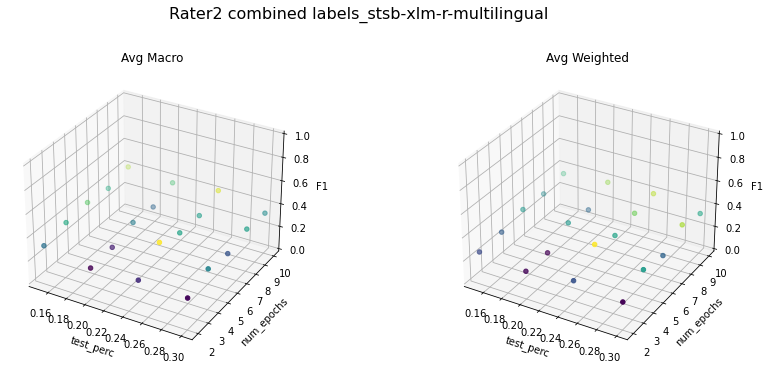

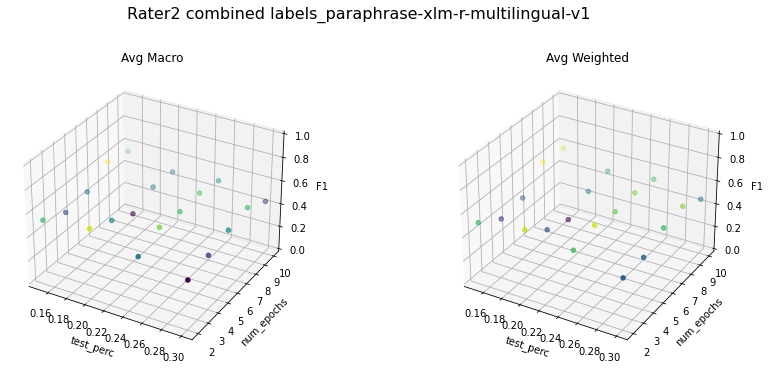

../input/F1_multiclass_results/EXPTEST1_FineTuningResults.json
[['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.15', 6, 0.7470913459266217], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.15', 4, 0.6935701156511513], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.3', 10, 0.6843093968756735]]


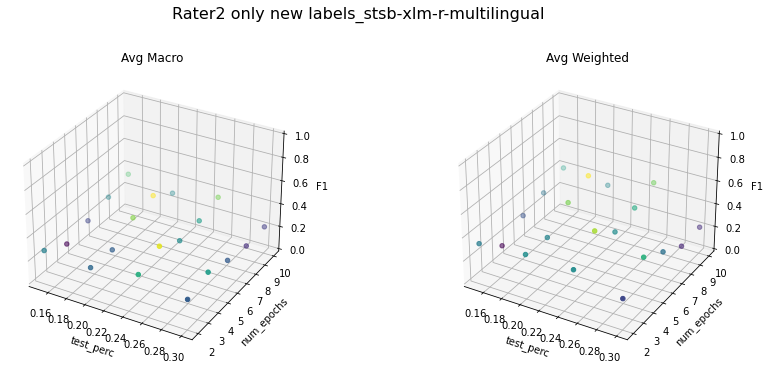

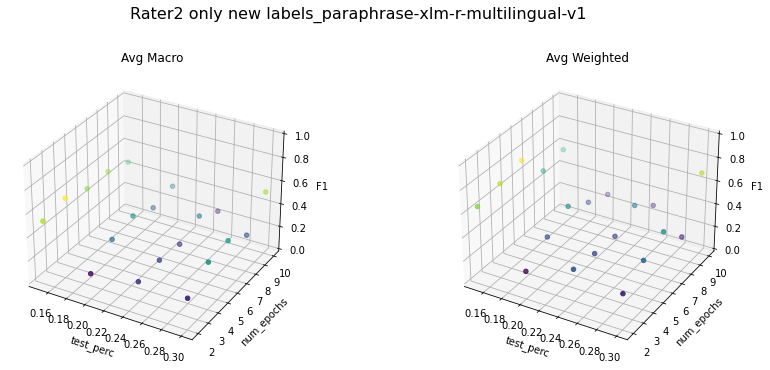

../input/F1_multiclass_results/EXPTEST2_FineTuningResults.json
[['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.25', 10, 0.8165888205361891], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.3', 6, 0.7649664277548348], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.25', 6, 0.7478709803347485]]


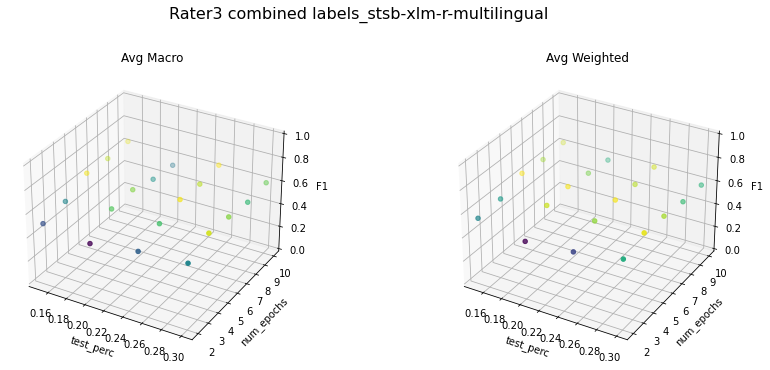

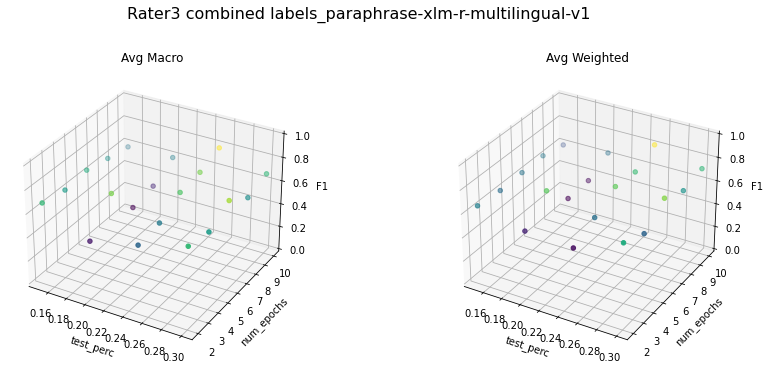

../input/F1_multiclass_results/EXPTEST3_FineTuningResults.json
[['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.25', 2, 0.5045533302104016], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.2', 2, 0.5025486768678551], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.3', 6, 0.46700349823187187]]


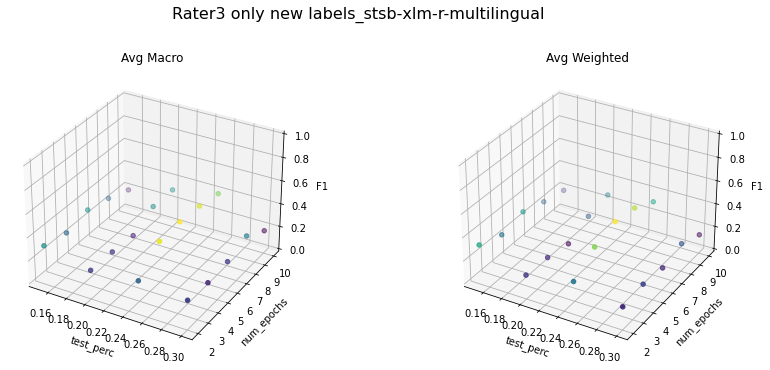

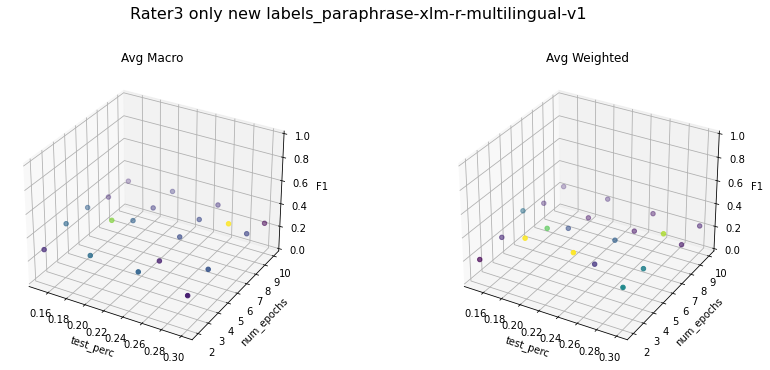

../input/F1_multiclass_results/EXPTEST4_FineTuningResults.json
[['stsb-xlm-r-multilingual', 'test_perc=0.3', 4, 0.7386038666825043], ['stsb-xlm-r-multilingual', 'test_perc=0.15', 2, 0.6840847140249829], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.3', 4, 0.6726490360099383]]


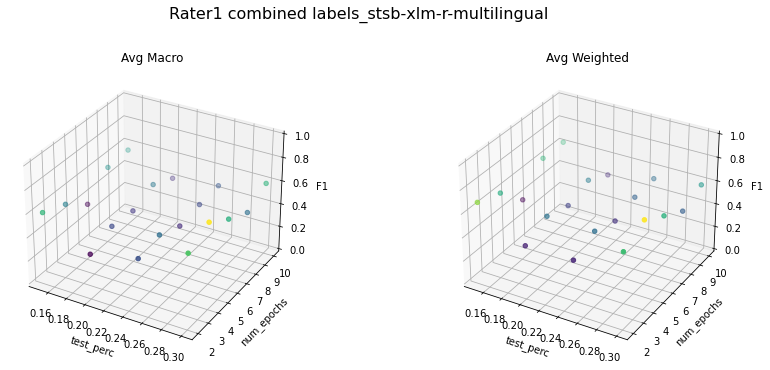

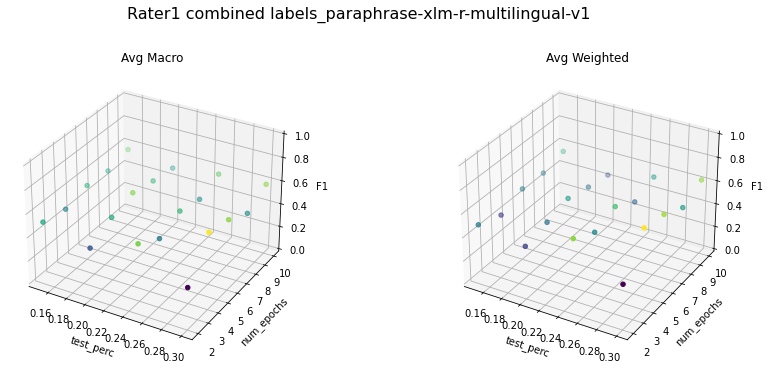

../input/F1_multiclass_results/EXPTEST5_FineTuningResults.json
[['stsb-xlm-r-multilingual', 'test_perc=0.15', 6, 0.5485256410256409], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.25', 4, 0.5281432748538011], ['stsb-xlm-r-multilingual', 'test_perc=0.15', 4, 0.521095571095571]]


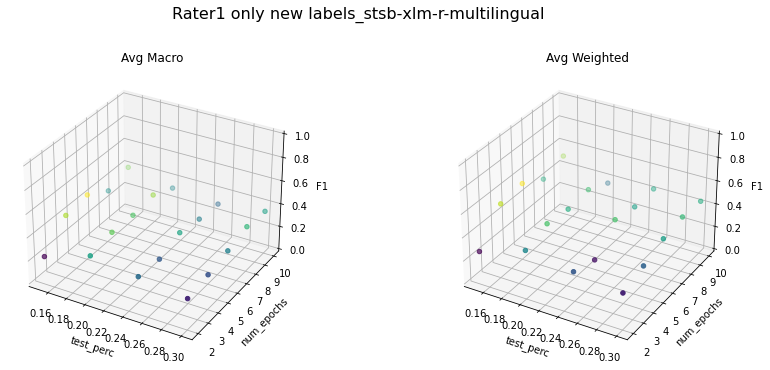

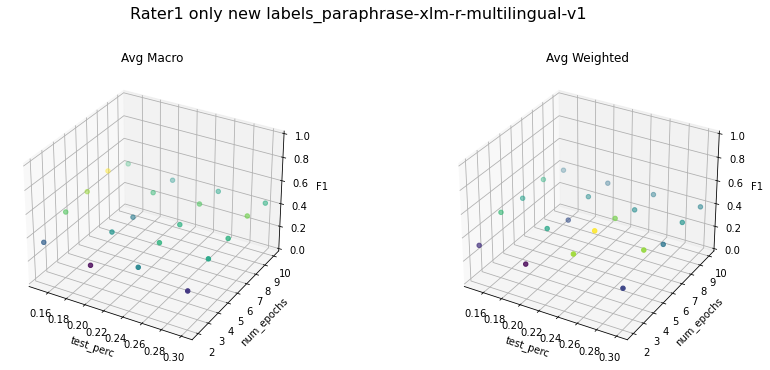

In [13]:
# path = Path("C:/Users/user/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Notebooks/Data/finetuningResults")
# filename = "FineTuningResults.json"

# sub_path = Path("C:/Users/user/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Notebooks/Data/finetuningResults/")
# paths = sub_path.glob('*.json')


models = ["stsb-xlm-r", "paraphrase-xlm-r"]#"distiluse-base", "quora-distilbert", 

exp_codes = {'0' : "Rater2 combined labels",
            '1' : "Rater2 only new labels",
            '2' : "Rater3 combined labels",
            '3' : "Rater3 only new labels",
            '4' : "Rater1 combined labels",
            '5' : "Rater1 only new labels"}

# exp_codes = {'20' : "Rater3",
#             '21' : "Rater2",
#             '22' : "Rater1"}

results_path = "../input/F1_multiclass_results/"
output_path = "../output/"
all_files = [os.path.join(root, file) for root, dirs, files in os.walk(results_path) for file in files]
exp_results_json = [file for file in all_files if file.endswith(".json")]

for exp_result in exp_results_json:
    print(exp_result)
    if "EXPTEST" in exp_result:
        exp_number = exp_result.split("EXPTEST")[1].split("_")[0]
#         if int(exp_number) > 19:
        with open(exp_result, "r") as f:
            F1 = json.load(f)
        select_best_scores(F1)
        plot_F1(transform_data(F1), exp_number, exp_codes, output_path)

# for path in paths:
#     # because path is object not string
#     path_in_str = str(path)
#     exp_number = path_in_str.split("EXP")[1].split("_")[0]
#     print(exp_number)
#     print(path_in_str)
#     if int(exp_number) > 9:
#         with open(path_in_str, "r") as f:
#             F1 = json.load(f)
#         plot_F1(transform_data(F1), exp_number, exp_codes, sub_path)